# Simple Linear Regression

In this Notebook, we will take a look at building a simple Linear regression model using PyTorch.

In [28]:
import arrow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import torch
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader

In [9]:
data_source = "https://raw.githubusercontent.com/ashdehghan/ML_DS_Data/main/simple_regression_data/kc_house_data/kc_house_data.csv"
data = pd.read_csv(data_source)

## Data Exploration

In this notebook, we are only going to build a model. The assumption is that we have done our data exploration somewhere else.
So, we will just jump into data cleansing and model building

## Data Prep

Here, we will clean and prep our data for model building.
We will do the following:
* Define the features and target columns.
* Remove any *nan* or *null* values.
* Split the data into Train, Validation and Test.
* Standardize the data.

Here, the goal is predict the price, so we know beforehand what column to select. Similarly for features, we know that columns *id* and *date* are not going to be meaningful.

Since the *price* for each house is linked to a given date, we consider our data to be of time-series type. So we will sort it based on date, and split our Train/Test accordingly. Not doing somthing like this is ok, it just means you are solving a different problem.

In [10]:
feature_cols = []
target_col = ["price"]
for col in data.columns:
    if col not in ["id", "price", "date"]:
        feature_cols.append(col)

In [11]:
def prep_data(data, feature_cols, target_col):
    data = data.copy(deep=True)
    data.dropna(inplace=True)
    data["date"] = data["date"].apply(lambda x : x.split("/")[2]+"-"+x.split("/")[0]+"-"+x.split("/")[1])
    data["date"] = data["date"].apply(lambda x : arrow.get(x, "YYYY-M-D"))
    data.sort_values(by=["date"], ascending=True, inplace=True)

    X = data[feature_cols].values
    y = data[target_col].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, data
    

X_train, X_val, X_test, y_train, y_val, y_test, data_mod = prep_data(data, feature_cols, target_col)

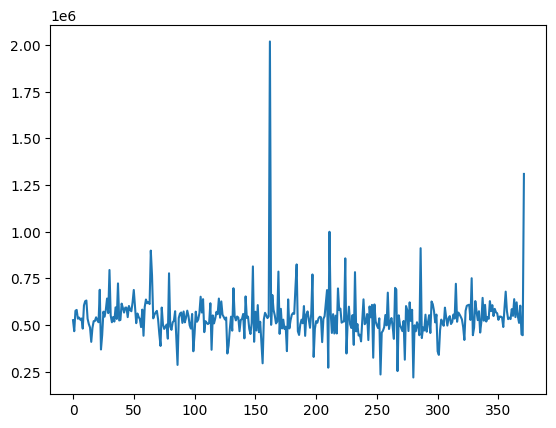

In [27]:
df = pd.DataFrame(data_mod.groupby(by=["date"])["price"].mean()).reset_index()
plt.plot(df["price"])
plt.show()

## Building the Model

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [6]:
class MLP(nn.Module):

    def __init__(self, input_dim):
        super().__init__()

        self.layers = nn.Sequential()
        self.layers.append(nn.Linear(input_dim, 32))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(32, 32))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(32, 1))

    def forward(self, x):
        output = self.layers(x)
        return output

In [7]:
input_dim = X_train.shape[1]

mlp = MLP(input_dim)

loss_function = nn.L1Loss()
loss_function_train = nn.L1Loss()
loss_function_val = nn.L1Loss()

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

dataset = Dataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

inputs_val = torch.from_numpy(X_val).float()
targets_val = torch.from_numpy(y_val).float()
targets_val = targets_val.reshape((targets_val.shape[0], 1))

inputs_train = torch.from_numpy(X_train).float()
targets_train = torch.from_numpy(y_train).float()
targets_train = targets_train.reshape((targets_train.shape[0], 1))

val_loss = []
train_loss = []
for epoch in tqdm(range(500)):

    for i, data in enumerate(trainloader, 0):

        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()
        train_outputs = mlp(inputs)        
        loss = loss_function(train_outputs, targets)
        loss.backward()
        optimizer.step()

    y_val_pred = mlp(inputs_val)    
    val_loss.append(loss_function_val(y_val_pred, targets_val).item())
    
    y_train_pred = mlp(inputs_train)
    train_loss.append(loss_function_train(y_train_pred, targets_train).item())
        
        
        


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.51it/s]


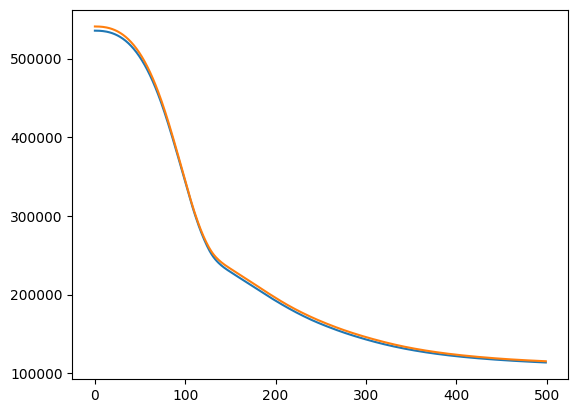

In [8]:
plt.plot(val_loss)
plt.plot(train_loss)
plt.show()

In [47]:
inputs_test = torch.from_numpy(X_test).float()
targets_test = torch.from_numpy(y_test).float()
targets_test = targets_test.reshape((targets_test.shape[0], 1))

In [48]:
test_pred = mlp(inputs_test).cpu().detach().numpy()

tensor([[1183660.1250],
        [ 768344.1250],
        [ 259208.2500],
        ...,
        [ 596917.2500],
        [ 199161.9219],
        [ 439240.4375]], grad_fn=<AddmmBackward0>)